In [44]:
## Run this cell if you need to install the required packages. 
## If possible do not install directly in global environment but rather use conda or virtualenv
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install scikit-learn
# !pip install seaborn
# !pip install imbalanced-learn

In [45]:
# Import standard libraries
import pandas as pd
import numpy as np

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for processing
from sklearn.model_selection import train_test_split
# Import SMOTE for balancing dataset
from imblearn.over_sampling import SMOTE

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Import measurement for evalutation
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, balanced_accuracy_score, roc_auc_score

In [46]:
# Set the style and context
sns.set_style("whitegrid", {'axes.facecolor': 'whitesmoke'})  # Change the plot area background color
sns.set_context("notebook")
palette = {0: "green", 1: "red"}  # Define the colors for the classes

# Declare variables and import data

In [47]:
# Random value define to ensure the same result is obtained each time the code is run
np.random.seed(36)

In [48]:
# Set the path to the dataset
path_train = "./A1_dataset/Paitients_Files_Train.csv"
path_test = "./A1_dataset/Paitients_Files_Test.csv"

In [49]:
# Define type of columns
target_col = ['Sepssis'] # Target column binary classification 
num_cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

In [50]:
# Load the data
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

In [51]:
train.shape, test.shape

((599, 11), (169, 10))

In [52]:
def print_overview(data):
    # Check if there are any object (non-numeric) columns
    object_columns = data.select_dtypes(include='object').columns
    int_columns = data.select_dtypes(include=['int64','float64']).columns
    
    # Display the top 3 rows
    print("Top 3 rows:" + '-'*70)
    display(data.head(3))

    # Display data types, missing values, and memory usage
    print("Data types, missing values, and memory usage:" + '-'*50)
    display(data.info())
    
    # Display summary statistics for numeric columns
    print("Summary statistics for numeric" + '-'*50)
    display(data.describe())
    print()
    print("Skewness for numeric" + '-'*50)
    display(data[int_columns].skew())
        
    # Conditionally display summary statistics for non-numeric columns
    print("Summary statistics for non-numeric" + '-'*50)
    if len(object_columns) > 0:
        display(data.describe(include='object'))

# Data Exploration
Using statistic and visual to explore the data.

In [53]:
print_overview(train)
#print_overview(test)

Top 3 rows:----------------------------------------------------------------------


,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive


Data types, missing values, and memory usage:--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


None

Summary statistics for numeric--------------------------------------------------


,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484,0.686144
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446,0.464447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,1.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Skewness for numeric--------------------------------------------------


PRG          0.914008
PL           0.116180
PR          -1.874662
SK           0.164063
TS           2.401585
M11         -0.405255
BD2          1.989472
Age          1.152353
Insurance   -0.804257
dtype: float64

Summary statistics for non-numeric--------------------------------------------------


,ID,Sepssis
count,599,599
unique,599,2
top,ICU200010,Negative
freq,1,391


In [54]:
# Re-encode the target column to 0 (Negative - Not developing Sepsis) and 1(Positive - Will develop Sepsis)
train['Sepssis'] = train['Sepssis'].map({'Negative': 0, 'Positive': 1})

In [55]:
# Define non attribute columns to remove
non_attribute_cols = ['ID','Insurance']

# Remove non-attribute columns 
train = train.drop(columns = non_attribute_cols)

# Visual Exploration

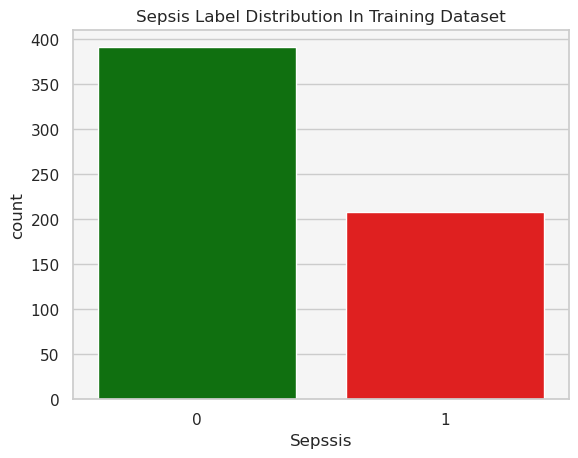

In [56]:
# Bar plot of target columns
plot = sns.countplot(x='Sepssis', hue = "Sepssis", data=train['Sepssis'].reset_index(), palette=palette, legend=False)
plt.title('Sepsis Label Distribution In Training Dataset')
plt.savefig('graphs/Target_distribution_training.png')

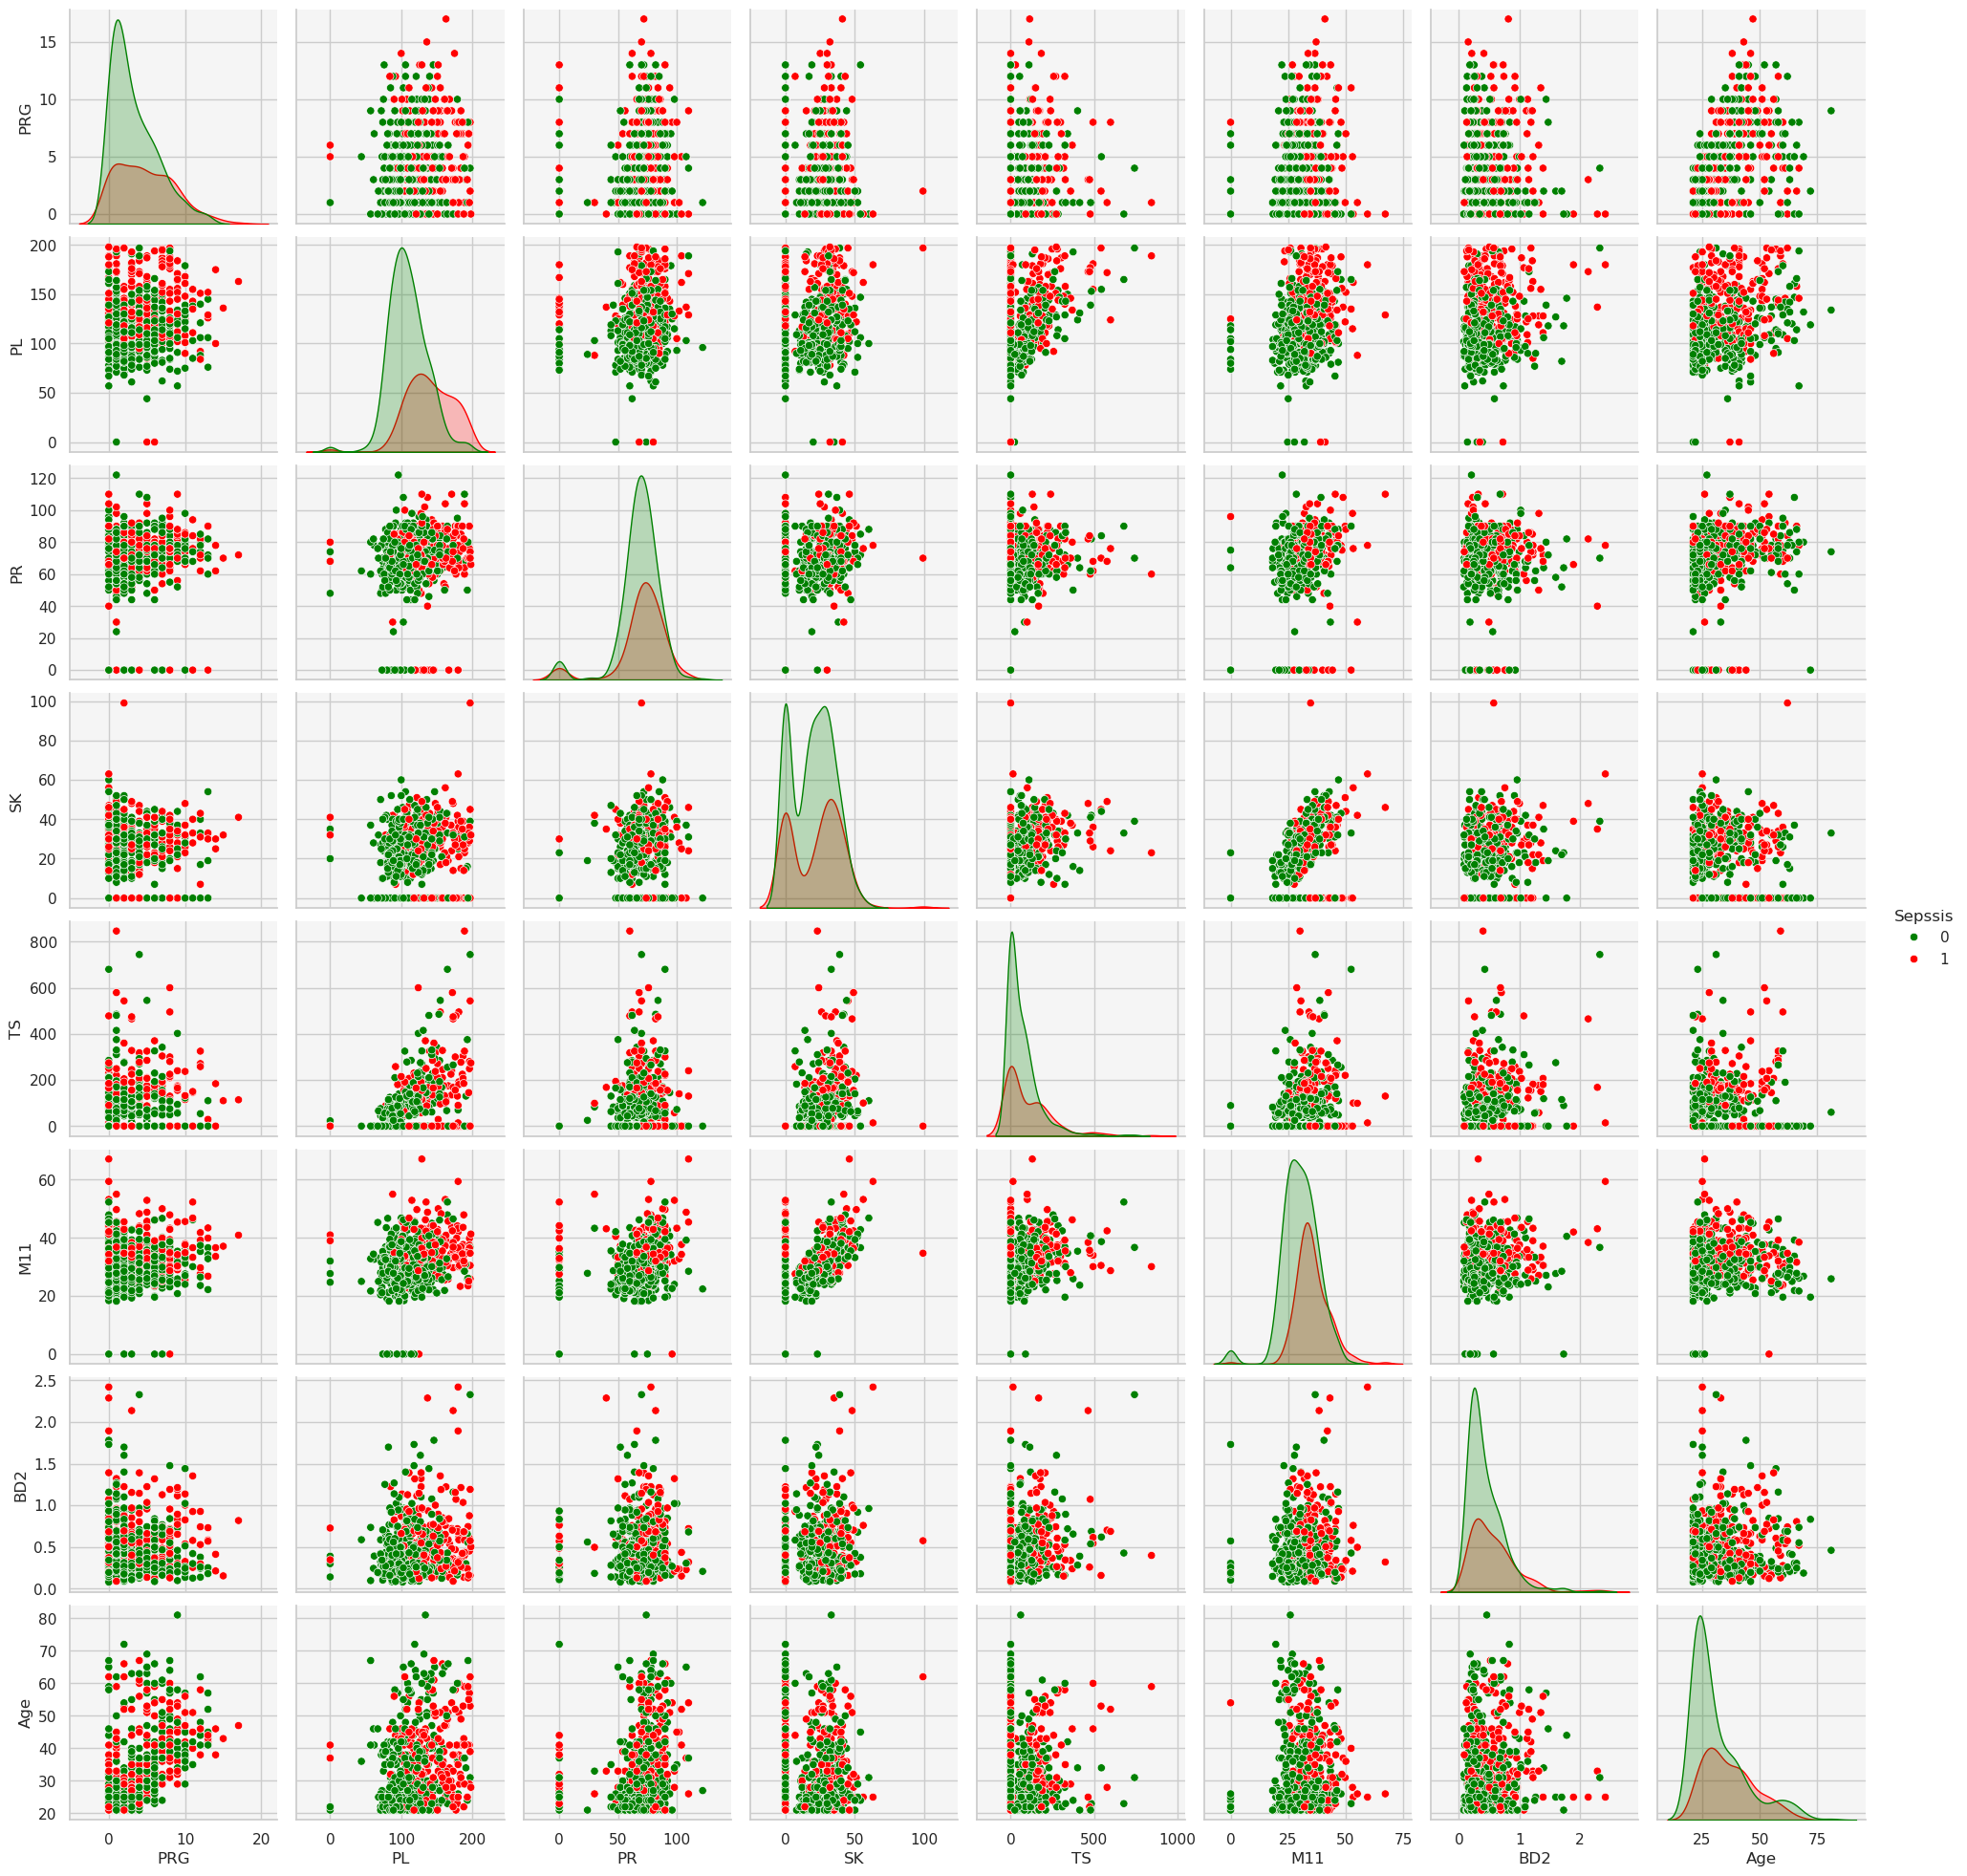

In [57]:
# Pairplot
sns.pairplot(train, hue = 'Sepssis', palette=palette)
plt.savefig('graphs/Pairplot.png')
plt.show()

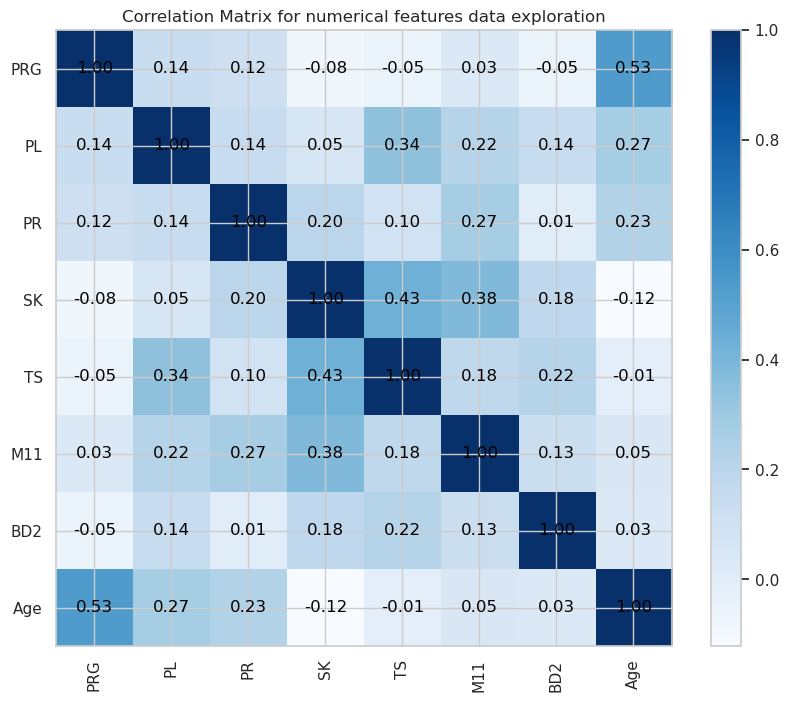

In [58]:
# correlation analysis
corrMatrix = train[num_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corrMatrix, cmap='Blues')
plt.title("Correlation Matrix for numerical features data exploration")
plt.colorbar()

# Add labels to the x-axis and y-axis
plt.xticks(range(len(corrMatrix.columns)), corrMatrix.columns, rotation=90)
plt.yticks(range(len(corrMatrix.columns)), corrMatrix.columns)

# Add the numerical data to each cell and format the text to center with back as the main color
for i in range(len(corrMatrix.columns)):
    for j in range(len(corrMatrix.columns)):
        plt.text(j,i ,f'{corrMatrix.iloc[i,j]:.2f}', ha = 'center', va = 'center', color ='black')

# Save the figure as an image
plt.savefig('graphs/feature_cor_matrix.png')
plt.show()

# Handling Missing Data

Replace place holder data 0 with NaN to determine how to preprocecssing them

In [59]:
# Replace 0 with NaN since most of the medical data measurement cannot be 0
train[num_cols] = train[num_cols].replace(value = np.nan, to_replace = 0)

In [60]:
# Check for missing values
train.isnull().sum()

PRG         93
PL           5
PR          28
SK         175
TS         289
M11          9
BD2          0
Age          0
Sepssis      0
dtype: int64

Since SK and TS contain a large amount of missing data we will need to address them otherwise the data will have problem.

Check the change after remove the missing value for later preprocess using pipeline.

In [61]:
# Check the change in the data
print_overview(train)

Top 3 rows:----------------------------------------------------------------------


,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1


Data types, missing values, and memory usage:--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PRG      506 non-null    float64
 1   PL       594 non-null    float64
 2   PR       571 non-null    float64
 3   SK       424 non-null    float64
 4   TS       310 non-null    float64
 5   M11      590 non-null    float64
 6   BD2      599 non-null    float64
 7   Age      599 non-null    int64  
 8   Sepssis  599 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 42.2 KB


None

Summary statistics for numeric--------------------------------------------------


,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
count,506.000000,594.000000,571.000000,424.000000,310.000000,590.000000,599.000000,599.000000,599.000000
mean,4.527668,121.164983,72.103327,29.049528,153.538710,32.406949,0.481187,33.290484,0.347245
std,3.194089,30.893218,12.197850,10.750992,122.023594,7.021781,0.337552,11.828446,0.476492
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.000000,64.000000,21.000000,74.000000,27.325000,0.248000,24.000000,0.000000
50%,4.000000,116.500000,72.000000,29.000000,120.000000,32.000000,0.383000,29.000000,0.000000
75%,7.000000,140.750000,80.000000,36.000000,190.000000,36.600000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Skewness for numeric--------------------------------------------------


PRG        0.907730
PL         0.537876
PR         0.131402
SK         0.801530
TS         2.266304
M11        0.620832
BD2        1.989472
Age        1.152353
Sepssis    0.643311
dtype: float64

Summary statistics for non-numeric--------------------------------------------------


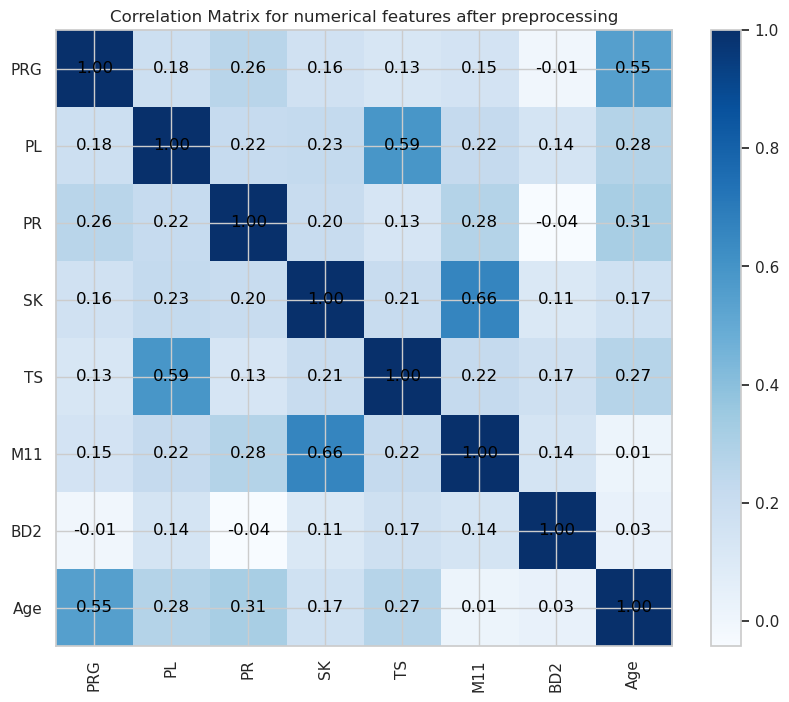

In [62]:
# correlation analysis
corrMatrix = train[num_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corrMatrix, cmap='Blues')
plt.title("Correlation Matrix for numerical features after preprocessing")
plt.colorbar()

# Add labels to the x-axis and y-axis
plt.xticks(range(len(corrMatrix.columns)), corrMatrix.columns, rotation=90)
plt.yticks(range(len(corrMatrix.columns)), corrMatrix.columns)

# Add the numerical data to each cell and format the text to center with back as the main color
for i in range(len(corrMatrix.columns)):
    for j in range(len(corrMatrix.columns)):
        plt.text(j,i ,f'{corrMatrix.iloc[i,j]:.2f}', ha = 'center', va = 'center', color ='black')

# Save the figure as an image
plt.savefig('graphs/feature_cor_matrix_2.png')
plt.show()

In [63]:
# Check feature correlation to target
corr_target = train[num_cols + target_col].corr()
corr_target = corr_target['Sepssis'].sort_values(ascending=False)
print(corr_target)

Sepssis    1.000000
PL         0.483579
M11        0.330034
TS         0.312529
PRG        0.262582
SK         0.259230
Age        0.210234
BD2        0.181561
PR         0.173591
Name: Sepssis, dtype: float64


## Train dev and split

To support the process we will be splitting the training dataset into train-dev set and validate-dev set use for training and validatation

In [64]:
# Modify the data into features and target
X = train.drop('Sepssis', axis = 1) # Features
y = train['Sepssis'] # Target

In [65]:
# Transform data into 2D array
X = np.array(X)
y = np.array(y)

In [66]:
# Train-dev and validation split for model training, stratify to ensure the same distribution of classes
X_train_dev, X_val, y_train_dev, y_val = train_test_split(X, y, test_size = 0.2, stratify=y)

In [67]:
X_train_dev.shape, X_val.shape, y_train_dev.shape, y_val.shape

((479, 8), (120, 8), (479,), (120,))

In [68]:
X_train_dev

array([[ 11.   , 135.   ,     nan, ...,  52.3  ,   0.578,  40.   ],
       [  7.   , 133.   ,  84.   , ...,  40.2  ,   0.696,  37.   ],
       [    nan,  67.   ,  76.   , ...,  45.3  ,   0.194,  46.   ],
       ...,
       [ 10.   ,  75.   ,  82.   , ...,  33.3  ,   0.263,  38.   ],
       [  7.   , 150.   ,  66.   , ...,  34.7  ,   0.718,  42.   ],
       [  5.   , 109.   ,  62.   , ...,  35.8  ,   0.514,  25.   ]])

# Data Preprocess

Building pipeline to standardise preprocessing steps to ensure consistent result and performance

In [69]:
# Import libraries for create pipeline for model training
from imblearn.pipeline import Pipeline 
# import libraries for handling missing values
from sklearn.impute import KNNImputer
# Import libraries for scaling
from sklearn.preprocessing import RobustScaler

In [70]:
k_nn = 3 # Number of nearest neighbors to use for KNN imputer

# Create a pipeline to use in the model and later for when predicting the test data
train_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=k_nn)), # Using KNN to handle missing values to ensure the data is not biased by the mean or median
    ('scaler', RobustScaler()), # Using RobustScaler to better handle outliers
    ('smote', SMOTE()) # Balancing the dataset only for training data
])

# Create a pipeline to handle the test/validation data
test_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=k_nn)),
    ('scaler', RobustScaler())
])

In [71]:
# Apply the pipeline to the training data
X_train_dev_reb, y_train_dev_reb= train_pipeline.fit_resample(X_train_dev, y_train_dev)

In [72]:
# Confirm the shape of the data
X_train_dev_reb.shape, y_train_dev_reb.shape

((626, 8), (626,))

In [73]:
# Apply the scaler to the validation data to ensure the same scaling is applied
X_val = test_pipeline.fit_transform(X_val)

# Model Comparion

Since the task is prediction of the class we will be starting with some simple model and moving it forward:

* Logistic Regression
* Simple K-mean
* SGD Classification
* Decision Tree
* RandomForestClassifier

Initally each model will be running using the training-dev and using CV technique (we will be using this since there is a small number of dimension in the data) to hyper tune each model. 

In [74]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

# create a pipeline for polynomial regression
PoliminalRegression = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_reduction', PCA(n_components=0.95)), # Reduce the number of features to 95% of the variance
    ('classification', LogisticRegression())
])

# Define the models to be used
models = {
    'Logistic Regression': LogisticRegression(),
    'Polynomial Regression': PoliminalRegression,
    'Stochastic Gradient Descent': SGDClassifier(loss='modified_huber'), # SGDClassifier is used with modified_huber loss function to compare with log loss
    'KNN': KNeighborsClassifier(), 
    'Decision Tree': DecisionTreeClassifier(), 
    'Random Forest': RandomForestClassifier(),
    }


# Define the list of parameter to search for 
param_distributions = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Polynomial Regression': {'poly__degree': [2,3,4,5,6],'classification__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Stochastic Gradient Descent': {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
    'KNN': {'n_neighbors': range(1,21)},
    'Decision Tree': {'max_depth': range(1,21)},
    'Random Forest': {'n_estimators': range(1, 200), 'max_depth': range(1, 21)}
}

In [75]:
import joblib # For saving best model
import time # For timing the training and testing

# Iterate throught the list of model and tune the hyperparameter
def models_training(models, param_distributions, iter_, cv_, score_val, save_model = False):
    for name, model in models.items():
        print(f'Randomise CV {name} on {score_val}')
        RandomSearch = RandomizedSearchCV(
            model, 
            param_distributions[name], # Use the parameter distribution for the model
            n_iter=iter_, 
            cv=cv_,  
            scoring = score_val,
            n_jobs=-1, # Use all available cores to speed up the process, adjust accordingly
        )

        train_start = time.time()
        RandomSearch.fit(X_train_dev_reb, y_train_dev_reb)
        train_end = time.time()
        train_time = train_end - train_start # Calculate the training time

        best_model = RandomSearch.best_estimator_
        y_pred = best_model.predict(X_val)

        cm = confusion_matrix(y_val, y_pred)
        
        print()
        print(f'Best parameters: {RandomSearch.best_params_}')
        print(f'Best Model {score_val} score: {RandomSearch.best_score_}')
        print(f'Model training time {train_time:.2f} seconds')
        print()
        print("="*30)
        print('Evaluation on the test/validation set:')
        # Following metrics are base on positive class of the target
        print(f'Test Balanced Accuracy Score: {balanced_accuracy_score(y_val, y_pred)}')
        print(f'Test Recall Score for Class 1: {recall_score(y_val, y_pred)}')
        print(f'Test F1-Score for Class 1: {f1_score(y_val, y_pred, average="binary")}')
        # Following metrics are base on the probability of the positive class of the target
        print(f'Test ROC AUC Score: {roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1])}')
        print(f'Test Classification Report:\n {classification_report(y_val, y_pred)}')
        print(f'Test Confusion Matrix:')
        print(cm)
        print()
        print("-"*60)

        # Save the model
        if save_model:
            joblib.dump(best_model, f'./models/{name}.pkl')

In [76]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore warnings for cleaner output, change this during development for debugging
warnings.filterwarnings('ignore')

# Train multiple models all at once (It will take some time to run)
# Models will be saved in the models folder if save_model is set to True, default is False
# Number of iteration is 200 and cross validation is set to 5 for each model
# The scoring is set to recall to capture as much positve class as possible as false negative if often more costly in medical
models_training(models, param_distributions,300,10,'recall', save_model = True) 

Randomise CV Logistic Regression on recall

Best parameters: {'C': 0.01}
Best Model recall score: 0.7319556451612904
Model training time 1.51 seconds

Evaluation on the test/validation set:
Test Balanced Accuracy Score: 0.6868131868131868
Test Recall Score for Class 1: 0.6428571428571429
Test F1-Score for Class 1: 0.6
Test ROC AUC Score: 0.7847985347985348
Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76        78
           1       0.56      0.64      0.60        42

    accuracy                           0.70       120
   macro avg       0.68      0.69      0.68       120
weighted avg       0.71      0.70      0.70       120

Test Confusion Matrix:
[[57 21]
 [15 27]]

------------------------------------------------------------
Randomise CV Polynomial Regression on recall

Best parameters: {'poly__degree': 2, 'classification__C': 1}
Best Model recall score: 0.7544354838709678
Model training time 7.89 secon

Since we run the risk of predicing the wrong range, random decision search would in theory proven to have better result than initial guessing.

# Final Model Result

Final model is the best model after the use of our above technique, we will then further tune it using the entirer train dataset prior to test it against the test dataset.

In [77]:
# Reload the best model selected from previous training
model = joblib.load('./models/Decision Tree.pkl')

# Apply the pipeline to the training data
X_train_reb, y_train_reb = train_pipeline.fit_resample(X, y)

# Retrain the model with the entire dataset
final_model = model.fit(X_train_reb,y_train_reb)

In [78]:
# Drop non-attribute columns
test_prep = test.drop(columns = non_attribute_cols)

In [79]:
# Reshape test data for prediction
test_prep = test_pipeline.fit_transform(test_prep)

In [80]:
# Check the shape of the data
test_prep.shape

(169, 8)

In [81]:
# Predict the test data
test_predic = final_model.predict(test_prep)

In [82]:
# Create a new dataframe to store the prediction which contain only ID and Prediction
prediction_df = pd.DataFrame({
    'ID': test['ID'],
    'Sepssis': test_predic
})

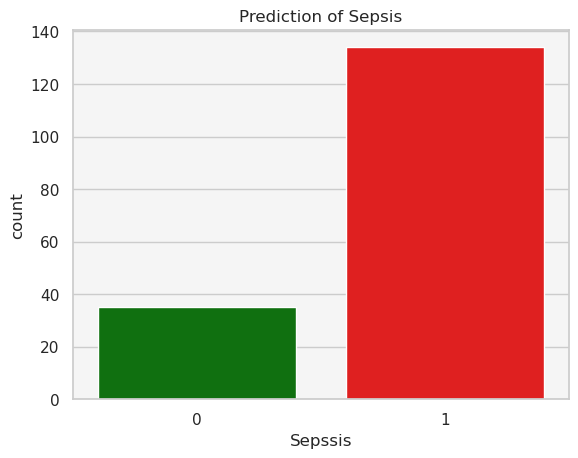

In [83]:
plot = sns.countplot(x='Sepssis', hue = 'Sepssis', data=prediction_df, palette = palette, legend = False)
plt.title('Prediction of Sepsis')
plt.savefig('graphs/test_prediction_distribution.png')

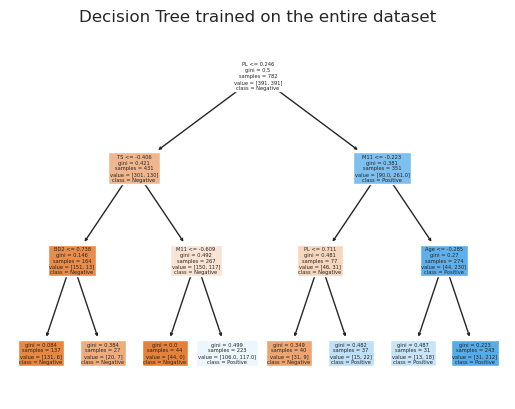

In [90]:
from sklearn.tree import plot_tree

plt.figure
plot_tree(final_model, filled=True, feature_names=train.drop('Sepssis', axis = 1).columns, class_names=['Negative', 'Positive'])
plt.title('Decision Tree trained on the entire dataset')
plt.show()

In [87]:
# Save the prediction to a csv file for submission
# Change the value to 1 to save the prediction
if 0:
    prediction_df.to_csv('03_PREDICTION_DangQuang_s3676330.csv', index=False)
    print('Previous prediction is overwritten!')
    print('Prediction is saved')

if 0:
    joblib.dump(final_model, 'models/final_best_model.pkl')
    print('Model is saved')

Previous prediction is overwritten!
Prediction is saved
Model is saved
